## **1. Tutorial**
> Original Source: https://huggingface.co/docs/diffusers/tutorials/tutorial_overview

```
> Understanding Pipelines, Models and Schedulers
> AutoPipeline
> Train a Diffusion Model
> Load LoRAs for Inference
> Accelerate Inference of Text-to-image Diffusion Models
> Working with Big Models
```

In [4]:
import os
import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import DiffusionPipeline
from diffusers import DDPMPipeline
from diffusers import DDPMScheduler, UNet2DModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler
from diffusers import AutoPipelineForText2Image
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.utils import make_image_grid
from accelerate import Accelerator
from accelerate import notebook_launcher

from diffusers import StableDiffusionXLPipeline
from torchao import swap_conv2d_1x1_to_linear
from torchao import apply_dynamic_quant

from dataclasses import dataclass
from datasets import load_dataset
from torchvision import transforms
import torch.nn.functional as F

W0515 09:22:36.068386 13608 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


---
### **Understanding Pipelines, Models and Schedulers**
- The **pipeline** denoises an image by taking random noise the size of the desired output and passing it through the model several times.
  - At each timestep, the model predicts the noise residual and the scheduler uses it to predict a less noisy image. The pipeline repeats this process until it reaches the end of the specified number of inference steps.

- The pipeline contains a `UNet2DModel` model and a `DDPMScheduler`.
  - The pipeline denoises an image by taking random noise the size of the desired output and passing it through the model several times.
  - At each timestep, the model predicts the noise residual and the scheduler uses it to predict a less noisy image.
  - The pipeline repeats this process until it reaches the end of the specified number of inference steps.

In [3]:
ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=25).images[0]

model_index.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

C:\Users\USER\anaconda3\envs\diffusers-t2i\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER\.cache\huggingface\hub\models--google--ddpm-cat-256. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

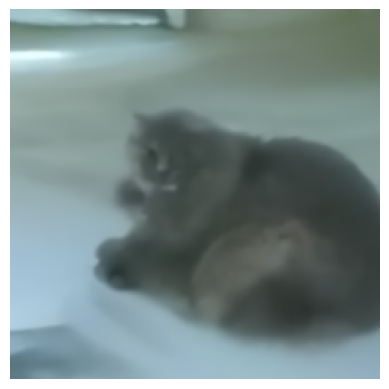

In [5]:
plt.imshow(image)
plt.axis("off")
plt.show()

#### Deconstruct a basic pipeline
- To recreate the pipeline with the model and scheduler separately, let’s write our own denoising process.

In [8]:
# 1. Load the model and scheduler
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

In [9]:
# 2. Set the number of timesteps to run the denoising process for
scheduler.set_timesteps(50)

- Setting the scheduler timesteps creates a tensor with evenly spaced elements in it.
  - Each element corresponds to a timestep at which the model denoises an image. 

In [10]:
# 3. When you create the denoising loop later, you’ll iterate over this tensor to denoise an image
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [11]:
# 4. Create some random noise with the same shape as the desired output
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

- **A loop to iterate over the timesteps**.
  - At each timestep, the model does a `UNet2DModel.forward()` pass and returns the noisy residual.
  - The scheduler’s `step()` method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep.
  - This output becomes the next input to the model in the denoising loop, and it’ll repeat until it reaches the end of the timesteps array.

- You’ll initialize the necessary components, and set the number of timesteps to create a timestep array.
  - The timestep array is used in the denoising loop, and for each element in this array, the model predicts a less noisy image.
- The denoising loop iterates over the timestep’s, and at each timestep, it outputs a noisy residual and the scheduler uses it to predict a less noisy image at the previous timestep.
- This process is repeated until you reach the end of the timestep array.

In [18]:
# 5. A loop to iterate over the timesteps
input = noise
for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

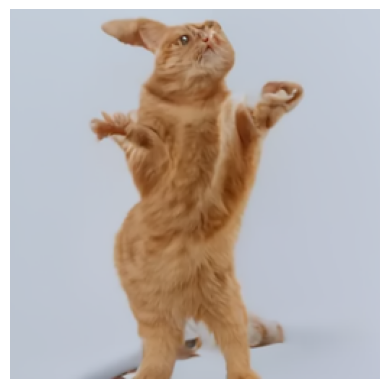

In [19]:
# 6. Convert the denoised output into an image
image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()

plt.imshow(image)
plt.axis("off")
plt.show()

#### Deconstruct the Stable Diffusion pipeline
- Stable Diffusion is a text-to-image latent diffusion model.
  - It works with a lower-dimensional representation of the image instead of the actual pixel space, which makes it more memory efficient.
  - The encoder compresses the image into a smaller representation, and a decoder converts the compressed representation back into an image.
  - For text-to-image models, you’ll need a tokenizer and an encoder to generate text embeddings.

<img src="figs/1-1.webp">

In [1]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

- Instead of the default `PNDMScheduler`, exchange it for the `UniPCMultistepScheduler` to see how easy it is to plug a different scheduler in:

In [23]:
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [24]:
torch_device = "cpu"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

#### Create Text Embeddings
- Tokenize the text to generate embeddings.
  - The text is used to condition the UNet model and steer the diffusion process towards something that resembles the input prompt.

In [66]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [67]:
# Tokenize the text and generate the embeddings from the prompt:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

- Generate the unconditional text embeddings which are the embeddings for the padding token.
  - These need to have the same shape (`batch_size` and `seq_length`) as the conditional text_embeddings:

In [68]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

- Concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes:

In [69]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#### Create Random Noise
- Generate some initial random noise as a starting point for the diffusion process.
  - This is the latent representation of the image, and it’ll be gradually denoised.
  - The latent image is smaller than the final image size but that’s okay though because the model will transform it into the final 512x512 image dimensions later.
- The height and width are divided by 8 because the vae model has 3 down-sampling layers. You can check by running the following: 

In [70]:
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [71]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

#### Denoise the image
- Start by scaling the input with the initial noise distribution, sigma, the noise scale value, which is required for improved schedulers like `UniPCMultistepScheduler`.

In [72]:
latents = latents * scheduler.init_noise_sigma

- MCreate the denoising loop that’ll progressively transform the pure noise in latents to an image described by your prompt.
  - The denoising loop needs to do three things:
    - Set the scheduler’s timesteps to use during denoising.
    - Iterate over the timesteps.
    - At each timestep, call the `UNet` model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

#### Decode the image
- The final step is to use the vae to decode the latent representation into an image and get the decoded output with sample:

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()

plt.imshow(image)
plt.axis("off")
plt.show()

----
### **AutoPipeline**

- `AutoPipeline` is a generic task-first pipeline that lets you focus on a task (`AutoPipelineForText2Image`, `AutoPipelineForImage2Image`, and `AutoPipelineForInpainting`) without needing to know the specific pipeline class.
  - The `AutoPipeline` automatically detects the correct pipeline class to use.
 
1. Detects a "stable-diffusion" class from the model_index.json file.
2. It loads the `StableDiffusionPipeline`. Any parameter (strength, num_inference_steps, etc.) you would pass to these specific pipelines can also be passed to the `AutoPipeline`.

In [4]:
pipe_txt2img = AutoPipelineForText2Image.from_pretrained(
    "dreamlike-art/dreamlike-photoreal-2.0", torch_dtype=torch.float16, use_safetensors=True).to("cuda")

prompt = "cinematic photo of Godzilla eating sushi with a cat in a izakaya, 35mm photograph, film, professional, 4k, highly detailed"
generator = torch.Generator(device="cpu").manual_seed(37)
image = pipe_txt2img(prompt, generator=generator).images[0]

---
### **Train a Diffusion Model**
- Unconditional image generation is a popular application of diffusion models that generates images that **look like those in the dataset used for training**.
- Typically, the best results are obtained from **finetuning** a pretrained model on a specific dataset.
- how to train a `UNet2DModel` from scratch on a subset of the `Smithsonian Butterflies` dataset to generate your own butterflies.

#### Training configuration
- For convenience, create a `TrainingConfig` class containing the training hyperparameters (feel free to adjust them):

In [14]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "ddpm-butterflies-128"  # the model name locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = None
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

#### Load the dataset
- You can easily load the `Smithsonian Butterflies` dataset with the Datasets library:

In [2]:
config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

C:\Users\USER\AppData\Local\Temp\ipykernel_17748\2340717843.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


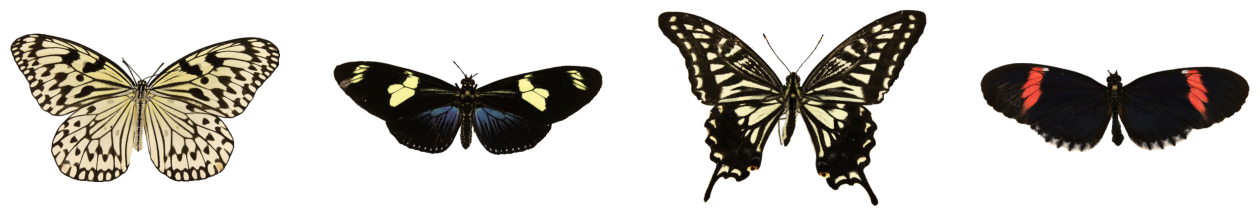

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

- The images are all different sizes though, so you’ll need to preprocess them first:
1. Resize changes the image size to the one defined in `config.image_size`.
2. `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
3. Normalize is important to rescale the pixel values into a [-1, 1] range, which is what the model expects.

In [23]:
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

- Use Datasets’ `set_transform` method to apply the preprocess function on the fly during training:

In [24]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

In [25]:
dataset.set_transform(transform)

- Wrap the dataset in a DataLoader for training

In [26]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

#### Create a UNet2DModel
- Pretrained models in Diffusers are easily created from their model class with the parameters you want.

In [28]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [30]:
sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Output shape:", model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


#### Create a scheduler
- The scheduler behaves differently depending on whether you’re using the model for **training or inference**.
  - During **inference**, the scheduler generates image from the noise.
  - During **training**, the scheduler takes a model output(sample) from a specific point in the diffusion process and applies noise to the image according to a noise schedule and an update rule.

- Look at the `DDPMScheduler` and use the `add_noise` method to add some random noise to the `sample_image` from before.

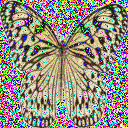

In [33]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

- The **training objective** is to predict the noise $\epsilon$ added to the input image $x_t$.  
  - The model is trained using the following mean squared error (MSE) loss function:
$$
\mathcal{L}_{\text{simple}}(\theta) = \mathbb{E}_{x_0, \epsilon, t} \left[ \left\| \epsilon - \hat{\epsilon}_\theta(x_t, t) \right\|_2^2 \right]
$$

- where

$$
x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon
$$

- and $\hat{\epsilon}_\theta(x_t, t)$ is the predicted noise output by the model parameterized by $\theta$.

In [35]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

#### Train the model
- You have most of the pieces to start training the model and all that’s left is putting everything together.
- First, you’ll need an optimizer and a learning rate scheduler:

In [37]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

- For evaluation, you can use the `DDPMPipeline` to generate a batch of sample images and save it as a grid:

In [39]:
def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

- You can wrap all these components together in a training loop with `Accelerate` for easy TensorBoard logging, gradient accumulation, and mixed precision training. 

In [46]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

- You’re ready to launch the training with Accelerate’s `notebook_launcher` function.
  - Pass the function the training loop, all the training arguments, and the number of processes (you can change this value to the number of GPUs available to you) to use for training:

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

- Once training is complete, generate the final images by your diffusion model!

In [ ]:
sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

---
### **Load LoRAs for inference**


- **Adapters** are small, trainable modules that are inserted into pre-trained models to fine-tune them for specific tasks or styles without modifying the entire model.
  - This approach significantly reduces computational costs and training time.

- One of the most popular and effective adapter techniques is **LoRA(Low-Rank Adaptation)**.
  - LoRA works by introducing **a pair of low-rank matrices into the attention layers** of a neural network.
  - Instead of updating all the weights in the model, LoRA allows the model to learn a small set of parameters that capture task-specific knowledge.

- Because LoRA adapters are lightweight and modular, you can train many different adapters, each specializing in a particular task or artistic style—like turning images into anime, mimicking a specific artist’s style, or adapting the model for medical imaging.      - Best of all, these adapters can be combined, giving rise to unique results that blend multiple characteristics together.

- With the integration of the **PEFT(Parameter-Efficient Fine-Tuning)** library in Diffusers, managing and loading these adapters becomes incredibly easy.
  - You no longer need to train large models from scratch or switch between multiple full models—just plug in the adapter you want to use.
 
- Load a pipeline with a Stable Diffusion XL (SDXL) checkpoint:

In [2]:
pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.float16).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

- Load a `CiroN2022/toy-face` adapter with the `load_lora_weights()` method.
  - With the PEFT integration, you can assign a specific adapter_name to the checkpoint, which lets you easily switch between different LoRA checkpoints. Let’s call this adapter "toy".

In [3]:
pipe

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
pipe.load_lora_weights("CiroN2022/toy-face", weight_name="toy_face_sdxl.safetensors", adapter_name="toy")

prompt = "toy_face of a hacker with a hoodie"
lora_scale = 0.9
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]

- With the `adapter_name` parameter, it is really easy to use another adapter for inference!
  - Load the `nerijs/pixel-art-xl` adapter that has been fine-tuned to generate pixel art images and call it "pixel".

- The pipeline automatically sets the first loaded adapter (`"toy"`) as the active adapter, but you can activate the "pixel" adapter with the `set_adapters()` method:

In [11]:
pipe.load_lora_weights("nerijs/pixel-art-xl", weight_name="pixel-art-xl.safetensors", adapter_name="pixel")
pipe.set_adapters("pixel")

In [ ]:
prompt = "a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": lora_scale}, generator=torch.manual_seed(0)
).images[0]
image

  0%|          | 0/30 [00:00<?, ?it/s]

#### Merge adapters
- You can also merge different adapter checkpoints for inference to blend their styles together.
- Once again, use the `set_adapters()` method to activate the pixel and toy adapters and specify the weights for how they should be merged.
- LoRA checkpoints in the diffusion community are almost always obtained with `DreamBooth`.
  - `DreamBooth` training often relies on “trigger” words in the input text prompts in order for the generation results to look as expected.
  - When you combine multiple LoRA checkpoints, it’s important to **ensure the trigger words for the corresponding LoRA checkpoints are present in the input text prompts**.

In [ ]:
pipe.set_adapters(["pixel", "toy"], adapter_weights=[0.5, 1.0])

- The model generated an image that mixed the characteristics of both adapters.

In [ ]:
prompt = "toy_face of a hacker with a hoodie, pixel art"
image = pipe(
    prompt, num_inference_steps=30, cross_attention_kwargs={"scale": 1.0}, generator=torch.manual_seed(0)
).images[0]
image

- To disable all adapters entirely, use the `disable_lora()` method to return the base model.

In [ ]:
pipe.disable_lora()

prompt = "toy_face of a hacker with a hoodie"
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

#### Customize adapters strength
- For even more customization, you can control how strongly the adapter affects each part of the pipeline.
  - For this, pass a dictionary with the control strengths (called “scales”) to `set_adapters()`.

In [ ]:
pipe.enable_lora()  # enable lora again, after we disabled it above
prompt = "toy_face of a hacker with a hoodie, pixel art"
adapter_weight_scales = { "unet": { "down": 1, "mid": 0, "up": 0} }
pipe.set_adapters("pixel", adapter_weight_scales)
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

- You can use it to control the adapter strengths down to per-transformer level.
  - And you can even use it for multiple adapters.

In [ ]:
adapter_weight_scales_toy = 0.5
adapter_weight_scales_pixel = {
    "unet": {
        "down": 0.9,  # all transformers in the down-part will use scale 0.9
        # "mid"  # because, in this example, "mid" is not given, all transformers in the mid part will use the default scale 1.0
        "up": {
            "block_0": 0.6,  # all 3 transformers in the 0th block in the up-part will use scale 0.6
            "block_1": [0.4, 0.8, 1.0],  # the 3 transformers in the 1st block in the up-part will use scales 0.4, 0.8 and 1.0 respectively
        }
    }
}
pipe.set_adapters(["toy", "pixel"], [adapter_weight_scales_toy, adapter_weight_scales_pixel])
image = pipe(prompt, num_inference_steps=30, generator=torch.manual_seed(0)).images[0]
image

#### Manage adapters
- You have attached multiple adapters in this tutorial, and if you’re feeling a bit lost on what adapters have been attached to the pipeline’s components, use the `get_active_adapters()` method to check the list of active adapters:

In [ ]:
active_adapters = pipe.get_active_adapters()
active_adapters

- You can also get the active adapters of each pipeline component with `get_list_adapters()`:

In [ ]:
list_adapters_component_wise = pipe.get_list_adapters()
list_adapters_component_wise

- The `delete_adapters()` function completely removes an adapter and their LoRA layers from a model.

In [ ]:
pipe.delete_adapters("toy")
pipe.get_active_adapters()

---
### **Accelerate Inference of Text-to-image Diffusion Models**
- Diffusion models are slower than their GAN counterparts because of the iterative and sequential reverse diffusion process.
  - There are several techniques that can **address this limitation such as progressive timestep distillation (LCM LoRA), model compression (SSD-1B), and reusing adjacent features of the denoiser (DeepCache)**.
  - However, you don’t necessarily need to use these techniques to speed up inference.
  - With PyTorch 2 alone, you can accelerate the inference latency of text-to-image diffusion pipelines by up to 3x.
  - This tutorial will show you how to progressively apply the optimizations found in PyTorch 2 to reduce inference latency.
    - You’ll use the **Stable Diffusion XL (SDXL)** pipeline in this tutorial, but these techniques are applicable to other text-to-image diffusion pipelines too.

#### Baseline
- Disable reduced precision and the `scaled_dot_product_attention (SDPA)` function which is automatically used by Diffusers:

In [8]:
# Load the pipeline in full-precision and place its model components on CUDA.
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0"
).to("cuda")

# Run the attention ops without SDPA.
pipe.unet.set_default_attn_processor()
pipe.vae.set_default_attn_processor()

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt, num_inference_steps=30).images[0]

#### bfloat16
- Enable the first optimization, reduced precision or more specifically `bfloat16`.
- There are several benefits of using reduced precision:
  - Using a reduced numerical precision (such as float16 or bfloat16) for inference **doesn’t affect the generation quality but significantly improves latency**.
- The benefits of using bfloat16 compared to float16 are hardware dependent, but modern GPUs tend to favor bfloat16.
  - bfloat16 is much **more resilient when used with quantization compared to float16**, but more recent versions of the quantization library (torchao) we used don’t have numerical issues with float16.

In [9]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.bfloat16
).to("cuda")

# Run the attention ops without SDPA.
pipe.unet.set_default_attn_processor()
pipe.vae.set_default_attn_processor()

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt, num_inference_steps=30).images[0]

#### SDPA
- Attention blocks are intensive to run but with PyTorch’s `scaled_dot_product_attention` function, it is a lot more efficient.
  - This function is used by default in Diffusers so you don’t need to make any changes to the code.

In [10]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.bfloat16
).to("cuda")

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt, num_inference_steps=30).images[0]

#### torch.compile
- PyTorch 2 includes `torch.compile` which uses fast and optimized kernels.
  - In Diffusers, the UNet and VAE are usually compiled because these are the most compute-intensive modules.
  - First, configure a few compiler flags (refer to the full list for more options):

In [11]:
torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.coordinate_descent_check_all_directions = True

- It is also important to change the UNet and VAE’s memory layout to `channels_last` when compiling them to ensure maximum speed.

In [12]:
pipe.unet.to(memory_format=torch.channels_last)
pipe.vae.to(memory_format=torch.channels_last)

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

- `torch.compile` offers different backends and modes.
  - **For maximum inference speed**, use `max-autotune` for the inductor backend.
  - `max-autotune` uses CUDA graphs and optimizes the compilation graph specifically for latency.
  - CUDA graphs greatly reduces the overhead of launching GPU operations by using a mechanism to launch multiple GPU operations through a single CPU operation.

- From PyTorch 2.3.1, you can [control](https://docs.pytorch.org/tutorials/recipes/torch_compile_caching_tutorial.html) the caching behavior of `torch.compile()`.
  - This is particularly beneficial for compilation modes like `max-autotune` which performs a grid-search over several compilation flags to find the optimal configuration.

In [13]:
# Compile the UNet and VAE.
pipe.unet = torch.compile(pipe.unet, mode="max-autotune", fullgraph=True)
pipe.vae.decode = torch.compile(pipe.vae.decode, mode="max-autotune", fullgraph=True)

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"

# First call to `pipe` is slow, subsequent ones are faster.
image = pipe(prompt, num_inference_steps=30).images[0]

#### Remove GPU sync after compilation
- Specifying `fullgraph=True` ensures there are no graph breaks in the underlying model to take full advantage of `torch.compile` without any performance degradation.
- For the UNet and VAE, this means changing how you access the return variables.

```
- latents = unet(
-   latents, timestep=timestep, encoder_hidden_states=prompt_embeds
-).sample

+ latents = unet(
+   latents, timestep=timestep, encoder_hidden_states=prompt_embeds, return_dict=False
+)[0]
```

#### Remove GPU sync after compilation
- During the iterative reverse diffusion process, the `step()` function is called on the scheduler each time after the denoiser predicts the less noisy latent embeddings.
  - Inside `step()`, the sigmas variable is indexed which when placed on the GPU, causes a communication sync between the CPU and GPU.
  - This introduces latency and it becomes more evident when the denoiser has already been compiled.

- But if the sigmas array always stays on the CPU, the CPU and GPU sync doesn’t occur and you don’t get any latency.
  - In general, any CPU and GPU communication sync should be none or be kept to a bare minimum because it can impact inference latency.
 
#### Combine the attention block’s projection matrices
- The UNet and VAE in SDXL use Transformer-like blocks which consists of attention blocks and feed-forward blocks.
  - In an attention block, the input is projected into three sub-spaces using three different projection matrices – $Q$, $K$, and $V$.
  - These projections are performed separately on the input. But we can horizontally combine the projection matrices into a single matrix and perform the projection in one step.
  - This increases the size of the matrix multiplications of the input projections and improves the impact of quantization.

- You can combine the projection matrices with just a single line of code:

In [ ]:
pipe.fuse_qkv_projections()

#### Dynamic quantization
- You can also use the ultra-lightweight PyTorch quantization library, `torchao (commit SHA 54bcd5a10d0abbe7b0c045052029257099f83fd9)`, to apply dynamic **int8 quantization to the UNet and VAE**.
  - Quantization adds additional conversion overhead to the model that is hopefully made up for by faster matmuls (dynamic quantization).
  - If the matmuls are too small, these techniques may degrade performance.

- First, configure all the compiler tags:

In [14]:
# Notice the two new flags at the end.
torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.epilogue_fusion = False
torch._inductor.config.coordinate_descent_check_all_directions = True
torch._inductor.config.force_fuse_int_mm_with_mul = True
torch._inductor.config.use_mixed_mm = True

- Certain linear layers in the UNet and VAE don’t benefit from dynamic int8 quantization.
  - You can filter out those layers with the `dynamic_quant_filter_fn` shown below.

In [16]:
def dynamic_quant_filter_fn(mod, *args):
    return (
        isinstance(mod, torch.nn.Linear)
        and mod.in_features > 16
        and (mod.in_features, mod.out_features)
        not in [
            (1280, 640),
            (1920, 1280),
            (1920, 640),
            (2048, 1280),
            (2048, 2560),
            (2560, 1280),
            (256, 128),
            (2816, 1280),
            (320, 640),
            (512, 1536),
            (512, 256),
            (512, 512),
            (640, 1280),
            (640, 1920),
            (640, 320),
            (640, 5120),
            (640, 640),
            (960, 320),
            (960, 640),
        ])

def conv_filter_fn(mod, *args):
    return (isinstance(mod, torch.nn.Conv2d) and mod.kernel_size == (1, 1) and 128 in [mod.in_channels, mod.out_channels])

- Apply all the optimizations discussed so far:

In [ ]:
# SDPA + bfloat16.
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.bfloat16
).to("cuda")

# Combine attention projection matrices.
pipe.fuse_qkv_projections()

# Change the memory layout.
pipe.unet.to(memory_format=torch.channels_last)
pipe.vae.to(memory_format=torch.channels_last)

- Since dynamic quantization is only limited to the linear layers, convert the appropriate pointwise convolution layers into linear layers to maximize its benefit.

In [2]:
swap_conv2d_1x1_to_linear(pipe.unet, conv_filter_fn)
swap_conv2d_1x1_to_linear(pipe.vae, conv_filter_fn)

apply_dynamic_quant(pipe.unet, dynamic_quant_filter_fn)
apply_dynamic_quant(pipe.vae, dynamic_quant_filter_fn)

- Compile and perform inference:

In [ ]:
pipe.unet = torch.compile(pipe.unet, mode="max-autotune", fullgraph=True)
pipe.vae.decode = torch.compile(pipe.vae.decode, mode="max-autotune", fullgraph=True)

prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt, num_inference_steps=30).images[0]

---------
### **Working with Big Models**
- A modern diffusion model, like SDXL, is not just a single model, but a collection of multiple models.
  - SDXL has four different model-level components: A variational autoencoder(VAE), Two text encoders, A UNet for denoising
 
- Usually, the text encoders and the denoiser are much larger compared to the VAE.
  - As models get bigger and better, it’s possible your model is so big that even a single copy won’t fit in memory.
  - But that doesn’t mean it can’t be loaded. If you have more than one GPU, there is more memory available to store your model.
  - In this case, it’s **better to split your model checkpoint into several smaller checkpoint shards**.

- When a text encoder checkpoint has multiple shards, like T5-xxl for SD3, it is automatically handled by the `Transformers` library as it is a required dependency of Diffusers when using the `StableDiffusion3Pipeline`.
  - Transformers will automatically handle the loading of multiple shards within the requested model class and get it ready so that inference can be performed.
 
- The denoiser checkpoint can also have multiple shards and supports inference thanks to the `Accelerate` library.

In [5]:
unet = UNet2DConditionModel.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", subfolder="unet"
)
unet.save_pretrained("sdxl-unet-sharded", max_shard_size="5GB")

- The size of the fp32 variant of the SDXL UNet checkpoint is ~10.4GB.
  - Set the `max_shard_size` parameter to 5GB to create 3 shards. After saving, you can load them in `StableDiffusionXLPipeline`:
  - If placing all the model-level components on the GPU at once is not feasible, use `enable_model_cpu_offload()` to help you:
- In general, we **recommend sharding when a checkpoint is more than 5GB** (in fp32).

In [8]:
unet = UNet2DConditionModel.from_pretrained(
    "sayakpaul/sdxl-unet-sharded", torch_dtype=torch.float16
)
pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16
).enable_model_cpu_offload()

image = pipeline("a cute dog running on the grass", num_inference_steps=30).images[0]
image.save("dog.png")

#### Device placement
- On distributed setups, you can run inference across multiple GPUs with Accelerate.
  - With `Accelerate`, you can use the `device_map` to determine how to distribute the models of a pipeline across multiple devices.   - This is useful in situations where you have more than one GPU.

- If you have two 8GB GPUs, then using `enable_model_cpu_offload()` may not work so well because:
  - It only works on a single GPU
  - A single model might not fit on a single GPU (`enable_sequential_cpu_offload()` might work but it will be extremely slow and it is also limited to a single GPU)
- To make use of both GPUs, you can use the “balanced” device placement strategy which splits the models across all available GPUs.
  - Only the “balanced” strategy is supported at the moment, and we plan to support additional mapping strategies in the future.

In [10]:
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", 
                                             torch_dtype=torch.float16, use_safetensors=True, device_map="balanced")
image = pipeline("a dog").images[0]
image

- You can also pass a dictionary to enforce the maximum GPU memory that can be used on each device:
- If a device is not present in `max_memory`, then it will be completely ignored and will not participate in the device placement.
- By default, Diffusers uses the maximum memory of all devices.
  - If the models don’t fit on the GPUs, they are offloaded to the CPU.
  - If the CPU doesn’t have enough memory, then you might see an error.
  - In that case, you could defer to using `enable_sequential_cpu_offload()` and `enable_model_cpu_offload()`.

In [ ]:
max_memory = {0:"1GB", 1:"1GB"}
pipeline = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True,
    device_map="balanced",
    max_memory=max_memory
)
image = pipeline("a dog").images[0]
image

- Call `reset_device_map()` to reset the `device_map` of a pipeline.
  - This is also necessary if you want to use methods like `to()`, `enable_sequential_cpu_offload()`, and `enable_model_cpu_offload()` on a pipeline that was device-mapped.
 
- Once a pipeline has been device-mapped, you can also access its device map via `hf_device_map`:

In [11]:
pipeline.reset_device_map()
print(pipeline.hf_device_map)